In [1]:
drop_val = 0.8

# LSTM binary

In [2]:
# Importing required libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Bidirectional, RNN
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
#Loading the dataset
data = pd.read_csv('Sarcasm Dataset.csv')

df = data.copy()
df.columns      

Index(['Unnamed: 0', 'tweet', 'sarcastic', 'sarcasm', 'irony', 'satire',
       'understatement', 'overstatement', 'rhetorical_question'],
      dtype='object')

In [8]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [5]:
import re
def cleaning(df):
    # coversion to lower Case
    df['tweet'] = df['tweet'].astype(str).apply(lambda x:' '.join(a.lower() for a in x.split()))

    # Replacing the special characters
    df['tweet'] = df['tweet'].str.replace('\W+', ' ')
#     df['tweet'] = df['tweet'].astype(str).apply(lambda s:''.join([i for i in s if i.isalnum()]))

    # Replacing the digits/numbers

    df['tweet'] = df['tweet'].astype(str).apply(lambda s:''.join([i for i in s if not i.isdigit()]))

    # Removing stop words

#     df['tweet'] = df['tweet'].astype(str).apply(lambda x: ' '.join(a for a in x.split() if a not in stop_words))

    # Lemmatization

    df['tweet'] = df['tweet'].astype(str).apply(lambda x:' '.join([Word(a).lemmatize() for a in x.split()]))

    return df

# stop_words = stopwords.words('english')

df = cleaning(df)
# df.head(20)

In [6]:
import string
sentences = [sublist.split() for sublist in df['tweet'].astype(str).values]
words = set([item for sublist in sentences for item in sublist])
vocab_size = len(words)
vocab_size

9447

In [7]:
df['tweet'] = df['tweet'].astype(str)

In [9]:
# split = round(len(df)*0.75)
# train_reviews = df['tweet'][:split]
# train_label = df['sarcastic'][:split]
# test_reviews = df['tweet'][split:]
# test_label = df['sarcastic'][split:]


In [10]:
# training_sentences = []
# training_labels = []
# testing_sentences = []
# testing_labels = []
# for row in train_reviews:
#     training_sentences.append(str(row))
# for row in train_label:
#     training_labels.append(row)
# for row in test_reviews:
#     testing_sentences.append(str(row))
# for row in test_label:
#     testing_labels.append(row)


In [11]:
import numpy as np
lengths = df["tweet"].str.len()
argmax = np.where(lengths == lengths.max())[0]
# max_len = len(data_v1.iloc[argmax]['tweet'])
max_length = lengths[argmax].astype(int)
print(max_length)
print(np.average(lengths))

2808    294
Name: tweet, dtype: int64
98.53979238754326


In [12]:
# data for binary 
X_train, X_test, y_train, y_test = train_test_split(df['tweet'].values,df['sarcastic'], test_size = 0.25, random_state = 42)
vocab_size = 9440
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [13]:
# data for multiclass
X_train_mn, X_test_mn, y_train_mn, y_test_mn = train_test_split(df.loc[df['sarcastic']==1, 'tweet'].values, df.loc[df['sarcastic']==1, ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']], test_size = 0.25, random_state = 42)
training_labels_final_mn = np.array(y_train_mn)
testing_labels_final_mn = np.array(y_test_mn)
# print(testing_labels_final_mn)
print('labels shape',testing_labels_final_mn.shape)
num_epochs = 20
vocab_size = 9440
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
tokenizer_mn = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_mn.fit_on_texts(X_train_mn)
word_index_mn = tokenizer_mn.word_index
sequences_mn = tokenizer_mn.texts_to_sequences(X_train_mn)
padded_mn = pad_sequences(sequences_mn, maxlen=max_length, truncating=trunc_type)
testing_sentences_mn = tokenizer_mn.texts_to_sequences(X_test_mn)
testing_padded_mn = pad_sequences(testing_sentences_mn, maxlen=max_length)

labels shape (217, 6)


# LSTM 2 -layered

In [14]:
# import tensorflow as tf
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='relu', input_shape=(360,1), return_sequences=True))
model.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='relu', ))
model.add(Dense(16,activation='tanh'))
model.add(Dense(1,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           151040    
                                                                 
 lstm (LSTM)                 (None, 120, 128)          74240     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 358,945
Trainable params: 358,945
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
82/82 [==============================] - 61s 671ms/step - loss: 0.5804 - accuracy: 0.2384 - val_loss: 0.6028 - val_accuracy: 0.2849
Epoch 2/20
82/82 [==============================] - 54s 663ms/step - loss: 0.5514 - accuracy: 0.2384 - val_loss: 0.5989 - val_accuracy: 0.2849
Epoch 3/20
82/82 [==============================] - 54s 662ms/step - loss: 0.5463 - accuracy: 0.2384 - val_loss: 0.6027 - val_accuracy: 0.2849
Epoch 4/20
82/82 [==============================] - 55s 668ms/step - loss: 0.5445 - accuracy: 0.2384 - val_loss: 0.6059 - val_accuracy: 0.2849
Epoch 5/20
82/82 [==============================] - 54s 664ms/step - loss: 0.5407 - accuracy: 0.2384 - val_loss: 0.6032 - val_accuracy: 0.2849
Epoch 6/20
82/82 [==============================] - 56s 687ms/step - loss: 0.5315 - accuracy: 0.2384 - val_loss: 0.6050 - val_accuracy: 0.2849
Epoch 7/20
82/82 [==============================] - 55s 666ms/step - loss: 0.5151 - accuracy: 0.2384 - val_loss: 0.6153 - val_accuracy: 0.2849

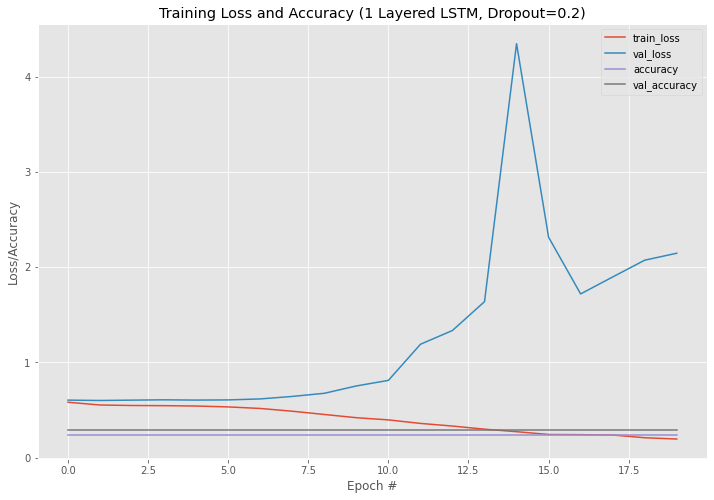

In [17]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history['accuracy'], label="accuracy")
plt.plot(N, history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (1 Layered LSTM, Dropout=0.2)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [18]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
 
# actual values
actual = testing_labels_final
# predicted values
predicted = model.predict(testing_padded)

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[247   0]
 [620   0]]
Outcome values : 
 247 0 620 0
Classification report : 
               precision    recall  f1-score   support

           1       0.28      1.00      0.44       247
           0       0.00      0.00      0.00       620

    accuracy                           0.28       867
   macro avg       0.14      0.50      0.22       867
weighted avg       0.08      0.28      0.13       867



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LSTM multi class 2 layered

In [19]:
import tensorflow as tf
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# model.add(SpatialDropout1D(0.4))
model2.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', input_shape=(360,1), return_sequences=True))
model2.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', ))
model2.add(Dense(36,activation='tanh'))
model2.add(Dense(6,activation='sigmoid'))
model2.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer='sgd', metrics = ['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           151040    
                                                                 
 lstm_2 (LSTM)               (None, 120, 128)          74240     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 36)                4644      
                                                                 
 dense_3 (Dense)             (None, 6)                 222       
                                                                 
Total params: 361,730
Trainable params: 361,730
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 20
history2 = model2.fit(padded_mn, training_labels_final_mn, epochs=num_epochs, validation_data=(testing_padded_mn, testing_labels_final_mn))

Epoch 1/20
21/21 [==============================] - 20s 694ms/step - loss: 2.0477 - accuracy: 0.7815 - val_loss: 1.8729 - val_accuracy: 0.8525
Epoch 2/20
21/21 [==============================] - 14s 664ms/step - loss: 1.8166 - accuracy: 0.8123 - val_loss: 1.6450 - val_accuracy: 0.8525
Epoch 3/20
21/21 [==============================] - 14s 664ms/step - loss: 1.6271 - accuracy: 0.8123 - val_loss: 1.4632 - val_accuracy: 0.8525
Epoch 4/20
21/21 [==============================] - 14s 665ms/step - loss: 1.4850 - accuracy: 0.8123 - val_loss: 1.3301 - val_accuracy: 0.8525
Epoch 5/20
21/21 [==============================] - 14s 674ms/step - loss: 1.3866 - accuracy: 0.8123 - val_loss: 1.2539 - val_accuracy: 0.8525
Epoch 6/20
21/21 [==============================] - 14s 667ms/step - loss: 1.3513 - accuracy: 0.8123 - val_loss: 1.2220 - val_accuracy: 0.8525
Epoch 7/20
21/21 [==============================] - 14s 667ms/step - loss: 1.3290 - accuracy: 0.8123 - val_loss: 1.2117 - val_accuracy: 0.8525

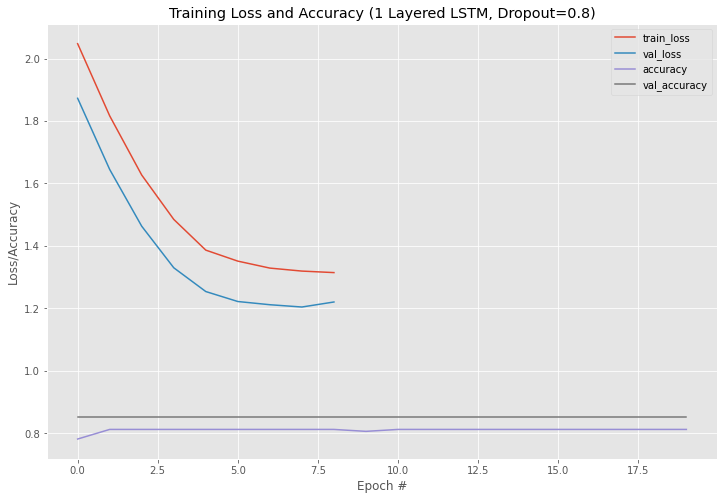

In [21]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history2.history["loss"], label="train_loss")
plt.plot(N, history2.history["val_loss"], label="val_loss")
plt.plot(N, history2.history['accuracy'], label="accuracy")
plt.plot(N, history2.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (1 Layered LSTM, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Vanilla RNN

In [22]:
# model3 = Sequential()
# model3.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# # model.add(SpatialDropout1D(0.4))
# model3.add(Dense(256,activation='relu'))
# model3.add(Dense(128,activation='tanh'))
# model3.add(Dense(1,activation='sigmoid'))
# model3.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
# model3.summary()
import tensorflow as tf
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           151040    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 128)               2176      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 169,857
Trainable params: 169,857
Non-trainable params: 0
________________________________________________

In [23]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history3 = model3.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
82/82 [==============================] - 1s 8ms/step - loss: 0.5785 - accuracy: 0.7616 - val_loss: 0.6165 - val_accuracy: 0.7151
Epoch 2/20
82/82 [==============================] - 0s 5ms/step - loss: 0.5513 - accuracy: 0.7616 - val_loss: 0.5984 - val_accuracy: 0.7151
Epoch 3/20
82/82 [==============================] - 0s 6ms/step - loss: 0.5462 - accuracy: 0.7616 - val_loss: 0.6002 - val_accuracy: 0.7151
Epoch 4/20
82/82 [==============================] - 0s 6ms/step - loss: 0.5398 - accuracy: 0.7616 - val_loss: 0.6084 - val_accuracy: 0.7151
Epoch 5/20
82/82 [==============================] - 0s 6ms/step - loss: 0.5188 - accuracy: 0.7616 - val_loss: 0.6274 - val_accuracy: 0.7151
Epoch 6/20
82/82 [==============================] - 0s 6ms/step - loss: 0.4550 - accuracy: 0.7778 - val_loss: 0.5939 - val_accuracy: 0.7174
Epoch 7/20
82/82 [==============================] - 0s 6ms/step - loss: 0.3178 - accuracy: 0.8647 - val_loss: 0.6784 - val_accuracy: 0.7059
Epoch 8/20
82/82 [==

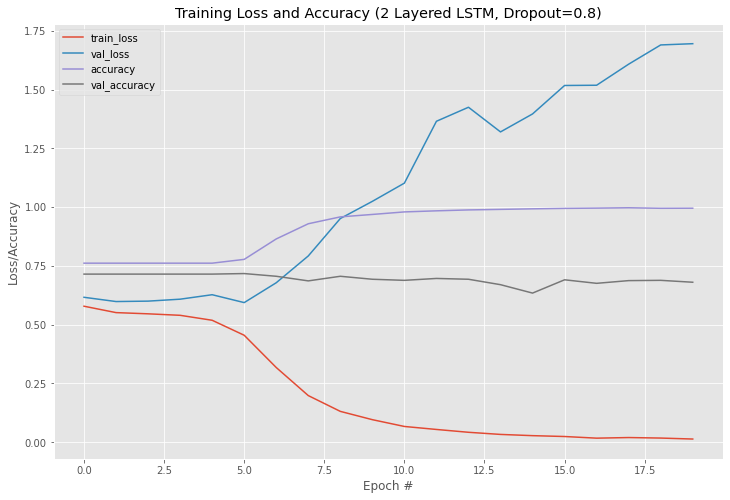

In [24]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history3.history["loss"], label="train_loss")
plt.plot(N, history3.history["val_loss"], label="val_loss")
plt.plot(N, history3.history['accuracy'], label="accuracy")
plt.plot(N, history3.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered LSTM, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [25]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
 
# actual values
actual = testing_labels_final
# predicted values
predicted = model3.predict(testing_padded)

# confusion matrix
matrix = confusion_matrix(actual,np.array([int((val-0.5)>0) for val in predicted]), labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,np.array([int((val-0.5)>0) for val in predicted]),labels=[1,0]).reshape(-1)
print('Outcome values (tp, fn, fp, tn): \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,np.array([int((val-0.5)>0) for val in predicted]),labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[ 52 195]
 [ 82 538]]
Outcome values (tp, fn, fp, tn): 
 52 195 82 538
Classification report : 
               precision    recall  f1-score   support

           1       0.39      0.21      0.27       247
           0       0.73      0.87      0.80       620

    accuracy                           0.68       867
   macro avg       0.56      0.54      0.53       867
weighted avg       0.64      0.68      0.65       867



# Vanilla RNN multiclass

In [26]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           151040    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 128)               2176      
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                                 
Total params: 170,502
Trainable params: 170,502
Non-trainable params: 0
________________________________________________

In [27]:
X_train_mn, X_test_mn, y_train_mn, y_test_mn = train_test_split(df.loc[df['sarcastic']==1, 'tweet'].values, df.loc[df['sarcastic']==1, ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']], test_size = 0.25, random_state = 42)
training_labels_final_mn = np.array(y_train_mn)
testing_labels_final_mn = np.array(y_test_mn)
# print(testing_labels_final_mn)
print('labels shape',testing_labels_final_mn.shape)
num_epochs = 20
vocab_size = 9440
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
tokenizer_mn = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_mn.fit_on_texts(X_train_mn)
word_index_mn = tokenizer_mn.word_index
sequences_mn = tokenizer_mn.texts_to_sequences(X_train_mn)
padded_mn = pad_sequences(sequences_mn, maxlen=max_length, truncating=trunc_type)
testing_sentences_mn = tokenizer_mn.texts_to_sequences(X_test_mn)
testing_padded_mn = pad_sequences(testing_sentences_mn, maxlen=max_length)

labels shape (217, 6)


In [28]:
history4 = model4.fit(padded_mn, training_labels_final_mn, epochs=num_epochs, validation_data=(testing_padded_mn, testing_labels_final_mn))

Epoch 1/20
21/21 [==============================] - 1s 14ms/step - loss: 2.0244 - accuracy: 0.8123 - val_loss: 1.7633 - val_accuracy: 0.8525
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 1.5196 - accuracy: 0.8123 - val_loss: 1.1821 - val_accuracy: 0.8525
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 1.3336 - accuracy: 0.8123 - val_loss: 1.2341 - val_accuracy: 0.8525
Epoch 4/20
21/21 [==============================] - 0s 7ms/step - loss: 1.3385 - accuracy: 0.8123 - val_loss: 1.2505 - val_accuracy: 0.8525
Epoch 5/20
21/21 [==============================] - 0s 7ms/step - loss: 1.3787 - accuracy: 0.8123 - val_loss: 1.3534 - val_accuracy: 0.8525
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 1.5319 - accuracy: 0.8123 - val_loss: 1.6247 - val_accuracy: 0.8525
Epoch 7/20
21/21 [==============================] - 0s 7ms/step - loss: 1.9393 - accuracy: 0.8123 - val_loss: 2.2105 - val_accuracy: 0.8525
Epoch 8/20
21/21 [=

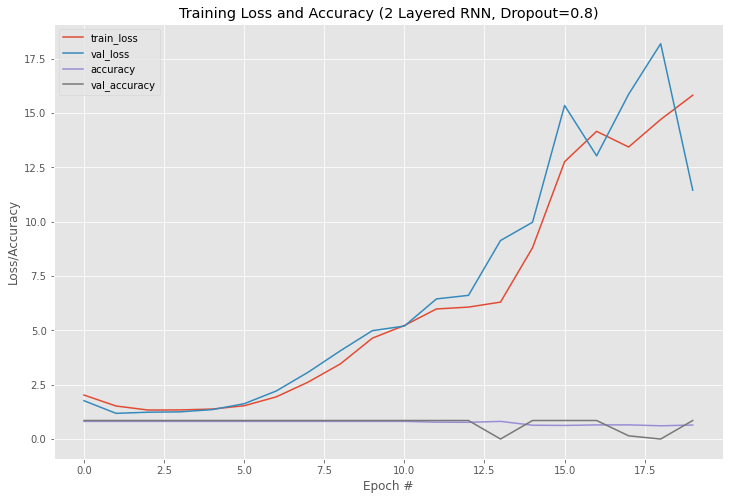

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history4.history["loss"], label="train_loss")
plt.plot(N, history4.history["val_loss"], label="val_loss")
plt.plot(N, history4.history['accuracy'], label="accuracy")
plt.plot(N, history4.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered RNN, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# GRU 2 layered binary

In [30]:
model5 = Sequential()
model5.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# model.add(SpatialDropout1D(0.4))
model5.add(GRU(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', input_shape=(360,1), return_sequences=True))
model5.add(GRU(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', ))
model5.add(Dense(36,activation='tanh'))
model5.add(Dense(1,activation='sigmoid'))
model5.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model5.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           151040    
                                                                 
 gru (GRU)                   (None, 120, 128)          56064     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_10 (Dense)            (None, 36)                4644      
                                                                 
 dense_11 (Dense)            (None, 1)                 37        
                                                                 
Total params: 310,857
Trainable params: 310,857
Non-trainable params: 0
_________________________________________________________________


In [31]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history5 = model5.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
82/82 [==============================] - 53s 582ms/step - loss: 0.5597 - accuracy: 0.7570 - val_loss: 0.5978 - val_accuracy: 0.7151
Epoch 2/20
82/82 [==============================] - 47s 576ms/step - loss: 0.5492 - accuracy: 0.7616 - val_loss: 0.6182 - val_accuracy: 0.7151
Epoch 3/20
82/82 [==============================] - 47s 574ms/step - loss: 0.5464 - accuracy: 0.7616 - val_loss: 0.5936 - val_accuracy: 0.7151
Epoch 4/20
82/82 [==============================] - 47s 578ms/step - loss: 0.5314 - accuracy: 0.7616 - val_loss: 0.5965 - val_accuracy: 0.7151
Epoch 5/20
82/82 [==============================] - 47s 574ms/step - loss: 0.4984 - accuracy: 0.7647 - val_loss: 0.5939 - val_accuracy: 0.7128
Epoch 6/20
82/82 [==============================] - 47s 577ms/step - loss: 0.4689 - accuracy: 0.7774 - val_loss: 0.6064 - val_accuracy: 0.6874
Epoch 7/20
82/82 [==============================] - 47s 574ms/step - loss: 0.4307 - accuracy: 0.8074 - val_loss: 0.6445 - val_accuracy: 0.6332

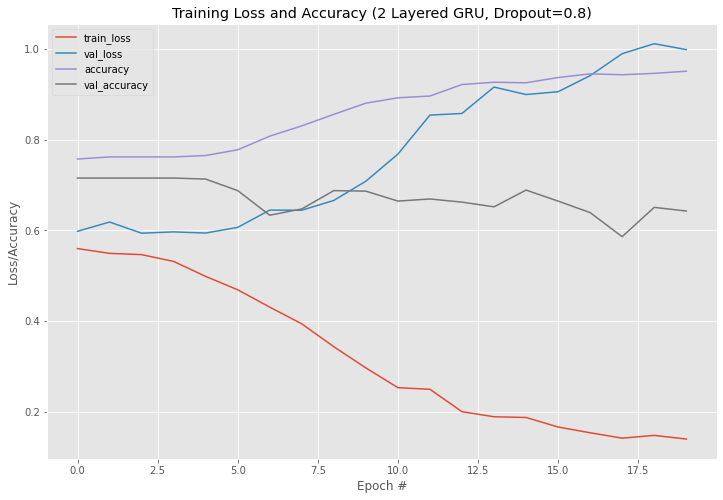

In [32]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history5.history["loss"], label="train_loss")
plt.plot(N, history5.history["val_loss"], label="val_loss")
plt.plot(N, history5.history['accuracy'], label="accuracy")
plt.plot(N, history5.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered GRU, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [33]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
 
# actual values
actual = testing_labels_final
# predicted values
predicted = model5.predict(testing_padded)

# confusion matrix
matrix = confusion_matrix(actual,np.array([int((val-0.5)>0) for val in predicted]), labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,np.array([int((val-0.5)>0) for val in predicted]),labels=[1,0]).reshape(-1)
print('Outcome values (tp, fn, fp, tn): \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,np.array([int((val-0.5)>0) for val in predicted]),labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[ 87 160]
 [150 470]]
Outcome values (tp, fn, fp, tn): 
 87 160 150 470
Classification report : 
               precision    recall  f1-score   support

           1       0.37      0.35      0.36       247
           0       0.75      0.76      0.75       620

    accuracy                           0.64       867
   macro avg       0.56      0.56      0.56       867
weighted avg       0.64      0.64      0.64       867



# GRU 2 Layered Multiclass

In [34]:
model6 = Sequential()
model6.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# model.add(SpatialDropout1D(0.4))
model6.add(GRU(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', input_shape=(360,1), return_sequences=True))
model6.add(GRU(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', ))
model6.add(Dense(36,activation='tanh'))
model6.add(Dense(6,activation='sigmoid'))
model6.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics = ['accuracy'])
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           151040    
                                                                 
 gru_2 (GRU)                 (None, 120, 128)          56064     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_12 (Dense)            (None, 36)                4644      
                                                                 
 dense_13 (Dense)            (None, 6)                 222       
                                                                 
Total params: 311,042
Trainable params: 311,042
Non-trainable params: 0
_________________________________________________________________


In [35]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history6 = model6.fit(padded_mn, training_labels_final_mn, epochs=num_epochs, validation_data=(testing_padded_mn, testing_labels_final_mn))

Epoch 1/20
21/21 [==============================] - 18s 611ms/step - loss: 1.7639 - accuracy: 0.7677 - val_loss: 1.5041 - val_accuracy: 0.8525
Epoch 2/20
21/21 [==============================] - 12s 581ms/step - loss: 1.5599 - accuracy: 0.8000 - val_loss: 1.4321 - val_accuracy: 0.8525
Epoch 3/20
21/21 [==============================] - 12s 584ms/step - loss: 1.4419 - accuracy: 0.8062 - val_loss: 1.3281 - val_accuracy: 0.8525
Epoch 4/20
21/21 [==============================] - 12s 578ms/step - loss: 1.3837 - accuracy: 0.8108 - val_loss: 1.3146 - val_accuracy: 0.8525
Epoch 5/20
21/21 [==============================] - 12s 582ms/step - loss: 1.3917 - accuracy: 0.8123 - val_loss: 1.3031 - val_accuracy: 0.8525
Epoch 6/20
21/21 [==============================] - 12s 578ms/step - loss: 1.3766 - accuracy: 0.8123 - val_loss: 1.2922 - val_accuracy: 0.8525
Epoch 7/20
21/21 [==============================] - 12s 579ms/step - loss: 1.3638 - accuracy: 0.8123 - val_loss: 1.2839 - val_accuracy: 0.8525

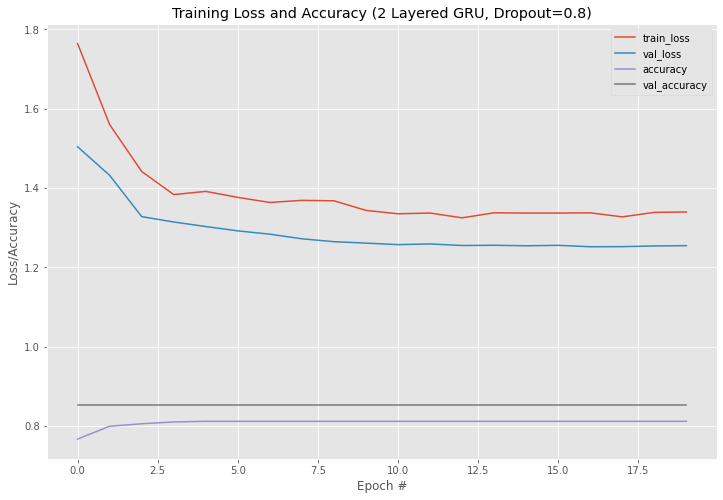

In [36]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history6.history["loss"], label="train_loss")
plt.plot(N, history6.history["val_loss"], label="val_loss")
plt.plot(N, history6.history['accuracy'], label="accuracy")
plt.plot(N, history6.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered GRU, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#BiLSTM

In [37]:
model7 = Sequential()
model7.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model7.add(Bidirectional(LSTM(20, return_sequences=True, dropout=drop_val, activation='LeakyReLU')))
model7.add(Bidirectional(LSTM(20, dropout=drop_val, activation='LeakyReLU')))
model7.add(Dense(36,activation='tanh'))
model7.add(Dense(1,activation='sigmoid'))
model7.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model7.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 16)           151040    
                                                                 
 bidirectional (Bidirectiona  (None, 120, 40)          5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 36)                1476      
                                                                 
 dense_15 (Dense)            (None, 1)                 37        
                                                                 
Total params: 168,233
Trainable params: 168,233
Non-tr

In [38]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history7 = model7.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
82/82 [==============================] - 22s 202ms/step - loss: 0.5764 - accuracy: 0.7562 - val_loss: 0.5994 - val_accuracy: 0.7151
Epoch 2/20
82/82 [==============================] - 16s 195ms/step - loss: 0.5489 - accuracy: 0.7616 - val_loss: 0.5967 - val_accuracy: 0.7151
Epoch 3/20
82/82 [==============================] - 16s 194ms/step - loss: 0.5466 - accuracy: 0.7616 - val_loss: 0.5980 - val_accuracy: 0.7151
Epoch 4/20
82/82 [==============================] - 16s 193ms/step - loss: 0.5282 - accuracy: 0.7616 - val_loss: 0.5915 - val_accuracy: 0.7151
Epoch 5/20
82/82 [==============================] - 16s 192ms/step - loss: 0.4937 - accuracy: 0.7616 - val_loss: 0.6028 - val_accuracy: 0.7151
Epoch 6/20
82/82 [==============================] - 16s 193ms/step - loss: 0.4523 - accuracy: 0.7789 - val_loss: 0.6231 - val_accuracy: 0.7036
Epoch 7/20
82/82 [==============================] - 16s 192ms/step - loss: 0.3790 - accuracy: 0.8451 - val_loss: 0.7596 - val_accuracy: 0.5675

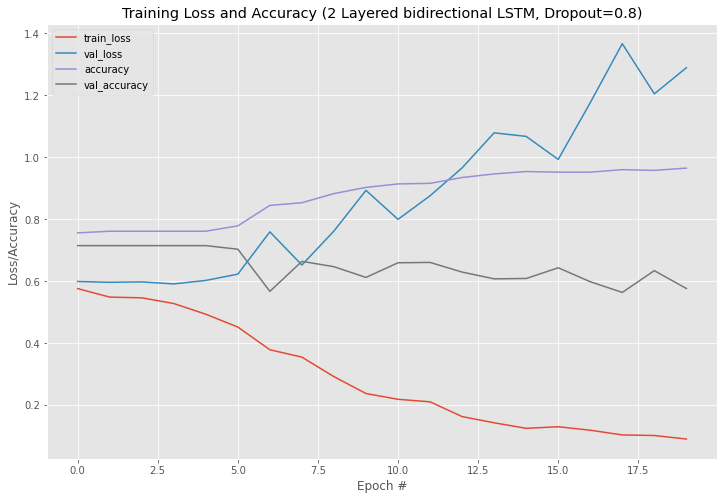

In [39]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history7.history["loss"], label="train_loss")
plt.plot(N, history7.history["val_loss"], label="val_loss")
plt.plot(N, history7.history['accuracy'], label="accuracy")
plt.plot(N, history7.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered bidirectional LSTM, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [40]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
 
# actual values
actual = testing_labels_final
# predicted values
predicted = model5.predict(testing_padded)

# confusion matrix
matrix = confusion_matrix(actual,np.array([int((val)>0) for val in predicted]), labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,np.array([int((val)>0) for val in predicted]),labels=[1,0]).reshape(-1)
print('Outcome values (tp, fn, fp, tn): \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,np.array([int((val)>0) for val in predicted]),labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[247   0]
 [620   0]]
Outcome values (tp, fn, fp, tn): 
 247 0 620 0
Classification report : 
               precision    recall  f1-score   support

           1       0.28      1.00      0.44       247
           0       0.00      0.00      0.00       620

    accuracy                           0.28       867
   macro avg       0.14      0.50      0.22       867
weighted avg       0.08      0.28      0.13       867



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#BiDirectional LSTM multi-class

In [41]:
model8 = Sequential()
model8.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model8.add(Bidirectional(LSTM(128, return_sequences=True, dropout=drop_val, activation='tanh')))
model8.add(Bidirectional(LSTM(128, dropout=drop_val, activation='tanh')))
model8.add(Dense(36,activation='tanh'))
model8.add(Dense(6,activation='sigmoid'))
model8.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics = ['accuracy'])
model8.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           151040    
                                                                 
 bidirectional_2 (Bidirectio  (None, 120, 256)         148480    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 36)                9252      
                                                                 
 dense_17 (Dense)            (None, 6)                 222       
                                                                 
Total params: 703,234
Trainable params: 703,234
Non-tr

In [42]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history8 = model8.fit(padded_mn, training_labels_final_mn, epochs=num_epochs, validation_data=(testing_padded_mn, testing_labels_final_mn))

Epoch 1/20
21/21 [==============================] - 26s 867ms/step - loss: 1.6791 - accuracy: 0.7800 - val_loss: 1.2428 - val_accuracy: 0.8525
Epoch 2/20
21/21 [==============================] - 16s 777ms/step - loss: 1.3401 - accuracy: 0.8123 - val_loss: 1.2875 - val_accuracy: 0.8525
Epoch 3/20
21/21 [==============================] - 16s 777ms/step - loss: 1.3254 - accuracy: 0.8123 - val_loss: 1.2294 - val_accuracy: 0.8525
Epoch 4/20
21/21 [==============================] - 16s 781ms/step - loss: 1.3307 - accuracy: 0.8123 - val_loss: 1.2281 - val_accuracy: 0.8525
Epoch 5/20
21/21 [==============================] - 16s 775ms/step - loss: 1.3335 - accuracy: 0.8123 - val_loss: 1.2178 - val_accuracy: 0.8525
Epoch 6/20
21/21 [==============================] - 16s 773ms/step - loss: 1.2985 - accuracy: 0.8123 - val_loss: 1.2215 - val_accuracy: 0.8525
Epoch 7/20
21/21 [==============================] - 16s 776ms/step - loss: 1.3250 - accuracy: 0.8123 - val_loss: 1.2246 - val_accuracy: 0.8525

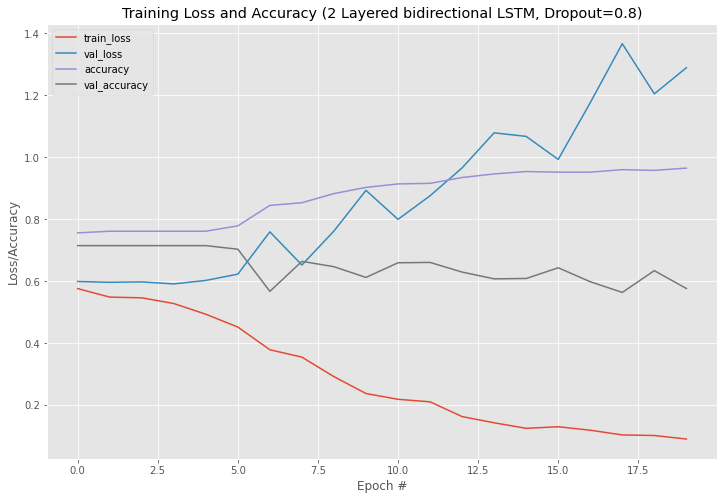

In [43]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history7.history["loss"], label="train_loss")
plt.plot(N, history7.history["val_loss"], label="val_loss")
plt.plot(N, history7.history['accuracy'], label="accuracy")
plt.plot(N, history7.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered bidirectional LSTM, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()